In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from sklearn.datasets import load_iris 

In [30]:
trainset = pd.read_csv('train.csv', index_col=0)
testset = pd.read_csv('test.csv', index_col=0)
def showBnd(inx):
    img = cv2.imread("./"+ trainset.new_path.iloc[inx])
    x1,y1,x2,y2 = trainset.iloc[inx, 2:]
    bnd_img = cv2.rectangle(img, (y1,x1), (y2,x2), (255,0,0), 2)
    print(trainset['class'].iloc[inx])
    return bnd_img

In [4]:
# load images from the folder
X_train = trainset.new_path.apply(lambda x: cv2.imread("./"+ x))
X_train = X_train.to_numpy()
X_test = testset.new_path.apply(lambda x: cv2.imread("./"+ x))
X_test = X_test.to_numpy()

In [5]:
# The size of each image is 300*477*3
X_train = [x.flatten() for x in X_train]
X_test = [x.flatten() for x in X_test]
X_train = np.array(X_train).reshape((676,300,447,3))
X_test = np.array(X_test).reshape((200,300,447,3))

In [6]:
X_train.shape, X_test.shape

((676, 300, 447, 3), (200, 300, 447, 3))

In [7]:
X_train = np.float32(X_train)
X_test = np.float32(X_test)
y1_train = tf.keras.utils.to_categorical(trainset['class'], num_classes=4)
y2_train = np.float32(trainset.iloc[:, 2:])

In [8]:
y1_train.shape, y2_train.shape

((676, 4), (676, 4))

In [9]:
inp = tf.keras.layers.Input(shape=(300,447,3))
x = tf.keras.layers.Conv2D(16, (3,3), activation='relu')(inp)
x = tf.keras.layers.Conv2D(16, (3,3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPool2D(2,2)(x)
x = tf.keras.layers.Dropout(.2)(x)

x = tf.keras.layers.Conv2D(32, (3,3), activation='relu')(x)
x = tf.keras.layers.Conv2D(32, (3,3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPool2D(2,2)(x)
x = tf.keras.layers.Dropout(.3)(x)

flatten = tf.keras.layers.Flatten()(x)
d1 = tf.keras.layers.Dense(128, activation='relu')(flatten)
d2 = tf.keras.layers.Dense(128, activation='relu')(d1)
out1 = tf.keras.layers.Dense(4,activation='softmax') (d2)
d3 = tf.keras.layers.Dense(256,activation='relu') (d2)
d4 = tf.keras.layers.Dense(256,activation='relu') (d3)
out2 = tf.keras.layers.Dense(4) (d4)

2022-05-08 19:06:41.267642: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
model=tf.keras.models.Model(inputs=inp, outputs=[out1,out2])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 447, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 298, 445, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 296, 443, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss=['categorical_crossentropy', 'mse'])

In [13]:
def lr_schedule(epoch, lr):
    if (epoch + 1)%5==0:
        lr *= .2
    return max(lr, 3e-7)

In [14]:
# 不必计算第二遍 no need for the second calculating
model.fit(X_train, [y1_train, y2_train], epochs=100, 
          callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_schedule)])

Epoch 1/100
22/22 [==============================] - 49s 2s/step - loss: 9695.1641 - dense_2_loss: 32.3880 - dense_5_loss: 9662.7764 - lr: 0.0010
Epoch 2/100
22/22 [==============================] - 48s 2s/step - loss: 3734.7329 - dense_2_loss: 25.6441 - dense_5_loss: 3709.0889 - lr: 0.0010
Epoch 3/100
22/22 [==============================] - 48s 2s/step - loss: 2541.8816 - dense_2_loss: 17.6695 - dense_5_loss: 2524.2122 - lr: 0.0010
Epoch 4/100
22/22 [==============================] - 48s 2s/step - loss: 1612.6006 - dense_2_loss: 16.4788 - dense_5_loss: 1596.1221 - lr: 0.0010
Epoch 5/100
22/22 [==============================] - 48s 2s/step - loss: 1046.4045 - dense_2_loss: 14.7674 - dense_5_loss: 1031.6373 - lr: 2.0000e-04
Epoch 6/100
22/22 [==============================] - 48s 2s/step - loss: 749.1194 - dense_2_loss: 13.2273 - dense_5_loss: 735.8921 - lr: 2.0000e-04
Epoch 7/100
22/22 [==============================] - 48s 2s/step - loss: 613.3740 - dense_2_loss: 12.4195 - dense_5_lo

22/22 [==============================] - 47s 2s/step - loss: 262.2537 - dense_2_loss: 9.9980 - dense_5_loss: 252.2557 - lr: 3.0000e-07
Epoch 57/100
22/22 [==============================] - 47s 2s/step - loss: 251.0395 - dense_2_loss: 9.5811 - dense_5_loss: 241.4584 - lr: 3.0000e-07
Epoch 58/100
22/22 [==============================] - 47s 2s/step - loss: 259.1454 - dense_2_loss: 9.6844 - dense_5_loss: 249.4609 - lr: 3.0000e-07
Epoch 59/100
22/22 [==============================] - 47s 2s/step - loss: 277.3931 - dense_2_loss: 9.8748 - dense_5_loss: 267.5183 - lr: 3.0000e-07
Epoch 60/100
22/22 [==============================] - 47s 2s/step - loss: 255.3894 - dense_2_loss: 9.6870 - dense_5_loss: 245.7023 - lr: 3.0000e-07
Epoch 61/100
22/22 [==============================] - 47s 2s/step - loss: 266.6888 - dense_2_loss: 9.9541 - dense_5_loss: 256.7347 - lr: 3.0000e-07
Epoch 62/100
22/22 [==============================] - 47s 2s/step - loss: 252.6644 - dense_2_loss: 9.5148 - dense_5_loss: 243

In [15]:
model.save("./the_saved_model.h5")

In [16]:
new_model = tf.keras.models.load_model("./the_saved_model.h5")

In [20]:
y1_pred, y2_pred = model.predict(X_train)

In [ ]:
y1_pred = y1_pred.argmax(axis=1)
y2_pred = np.int32(y2_pred)

In [62]:
def verify(inx):
    img = cv2.imread("./"+ trainset.new_path.iloc[inx])
    x1,y1,x2,y2 = y2_pred[inx, :]
    bnd_img = cv2.rectangle(img, (y1,x1), (y2,x2), (255,0,0), 2)
    print(y1_pred[inx])
    return bnd_img

1


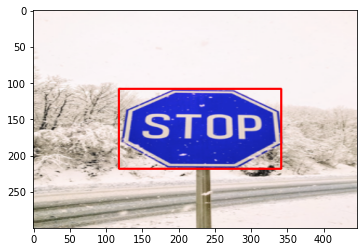

In [64]:
# illustration
bnd_img = showBnd(201)
plt.imshow(bnd_img)
plt.show()

0


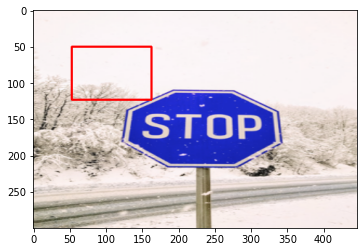

In [65]:
bnd_img = verify(201)
plt.imshow(bnd_img)
plt.show()

In [73]:
y1_pred, y2_pred = model.predict(X_test)
y1_pred = y1_pred.argmax(axis=1)

In [83]:
result = pd.DataFrame(np.c_[list(range(len(testset))), y1_pred, y2_pred])
result.columns = ['Id', 'class', 'x1', 'y1', 'x2', 'y2']
result[['Id', 'class']]= result[['Id', 'class']].astype(int)
result.set_index('Id', inplace=True)

In [96]:
result.to_csv('./submission.csv')